In [1]:
# !pip install pandas
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import sys
np.set_printoptions(threshold=500)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

teleplay_data = pd.read_csv('Teleplay.csv', sep=',')
rating_data = pd.read_csv('Rating.csv', sep=',')
#eliminate the data without rating
rating_data = rating_data[rating_data.rating > 0][['user_id','teleplay_id','rating']]

# rating_data = rating_data.groupby(['teleplay_id']).agg()
teleplay_rating = pd.merge(teleplay_data, rating_data,left_on="teleplay_id",right_on="teleplay_id")
# print(teleplay_rating)

teleplay_rating_mean = teleplay_rating.groupby(['teleplay_id'], as_index=False, sort=False).agg({'user_id':'count','rating_y' : 'mean'})\
.rename(columns={"user_id" : 'totalusers'}).sort_values(['totalusers'], ascending=False)

# print(teleplay_rating_mean)
# print(teleplay_rating.head())

#preprocessing
# ratings_df = rating_data.pivot_table(index='user_id', columns='teleplay_id', values='rating')
ratings_df = rating_data.groupby(['user_id', 'teleplay_id']).rating.sum().unstack()

# ratings_df = rating_data.pivot(index='user_id', columns='teleplay_id', values='rating')
# print(ratings_df)
ratings = ratings_df.fillna(0).values

print(ratings_df.head())
# print(np.isnan(ratings_df).any())

teleplay_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                      
1              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5              NaN    NaN    8.0    NaN    NaN    6.0    NaN    6.0    6.0   
7              NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

teleplay_id  19     ...  34238  34239  34240  34252  34283  34324  34325  \
user_id             ...                                                    
1              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5              NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN 

In [2]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [3]:
train, val = train_test_split(ratings)
print(train)
print(val)


[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [10.  0. 10. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0. 10.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [4]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    print("this is prediction",prediction)
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [5]:
class Recommender:
  
  def __init__(self, n_epochs=50, n_latent_features=3, lmbda=0.1, learning_rate=0.01):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
#         print("this is train_rmse",train_rmse)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
#         print("this is val_rmse",val_rmse)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()


this is prediction [5.36115234 5.00422044 5.4681262  ... 7.40532031 6.90976642 6.59301524]
this is prediction [8.08414859 7.44194287 7.37142668 ... 7.42113402 8.32379607 8.41006718]
this is prediction [6.82938876 6.39109714 6.98325608 ... 7.41041017 7.47615333 7.03982102]
this is prediction [7.53635021 6.86114651 6.7331388  ... 7.43123507 8.30849931 8.37393285]
this is prediction [7.82015237 7.33170205 8.00032929 ... 7.418632   7.78219876 7.33896723]
this is prediction [7.48943194 6.83043344 6.72277563 ... 7.4346262  8.30116507 8.35625619]
this is prediction [8.49881417 7.97509268 8.69968171 ... 7.42445565 8.0213817  7.57247121]
this is prediction [7.45730942 6.82017293 6.72067514 ... 7.43079154 8.30113832 8.35097013]
this is prediction [8.96746308 8.40700111 9.1828989  ... 7.42836455 8.23579792 7.74920512]
this is prediction [7.43870335 6.82016666 6.72044941 ... 7.41776176 8.30059607 8.35489452]
this is prediction [9.29336173 8.68366824 9.51611439 ... 7.4314064  8.45218724 7.8651663 ]

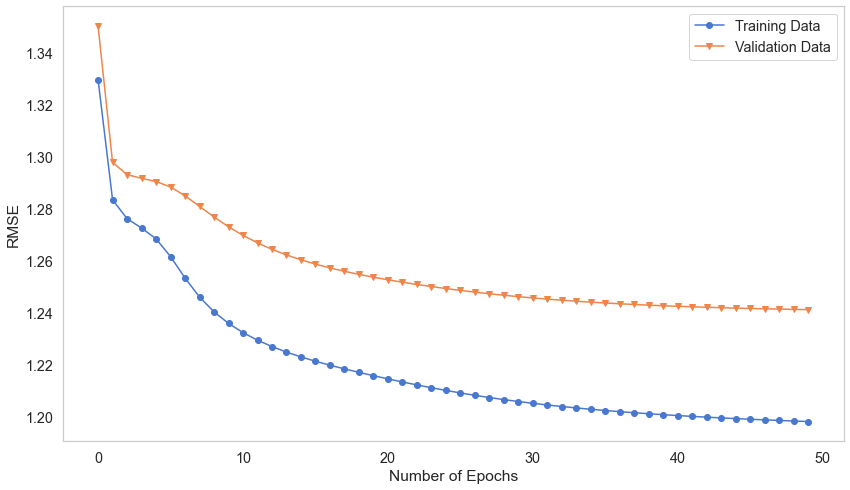

In [6]:
recommender = Recommender().fit(train, val)

plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [9]:

user_id = 53698
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

def create_teleplay_ratings(teleplay_df, teleplay_index, ratings, n=9927):
  teleplay_ids = ratings_df.columns[teleplay_index]
  teleplay_ratings = pd.DataFrame(data=dict(teleplayId=teleplay_ids, rating=ratings))
  top_n_teleplay = teleplay_ratings.sort_values("rating", ascending=False).head(n)
  
  teleplay_recommendations = teleplay_df[teleplay_df.teleplay_id.isin(top_n_teleplay.teleplayId)].reset_index(drop=True)
  teleplay_recommendations['rating'] = pd.Series(top_n_teleplay.rating.values)
  return teleplay_recommendations.sort_values("rating", ascending=False)

create_teleplay_ratings(teleplay_data, predictions_index, rating_predictions)

[[53698     1     6]
 [53698     5     6]
 [53698     6     7]
 ...
 [53698 31115     5]
 [53698 31137     6]
 [53698 31144     5]]
(2895, 3)


,teleplay_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",long,1,9.942151,200630
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",medium,51,9.265607,114262
2,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",medium,51,9.228303,151266
3,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",medium,10,9.113866,93351
4,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",medium,148,8.963782,425855
...,...,...,...,...,...,...,...
5845,5541,The Satisfaction,Restricted,short,1,4.821447,166
5846,9316,Toushindai My Lover: Minami tai Mecha-Minami,Restricted,short,1,4.821333,211
5847,5543,Under World,Restricted,short,1,4.820891,183
5848,5621,Violence Gekiga David no Hoshi,Restricted,short,4,4.820716,219
